In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pyfftw as ft
import time
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

In [2]:
N = 1024

In [3]:
Q = np.zeros((N,N,N),dtype='float32')
R = np.zeros((N,N,N),dtype='float32')
S2 = np.zeros((N,N,N), dtype='float32')

In [4]:
start = time.time()

nproc = 8
nx = N//nproc

lQ = np.zeros((N//nproc,N,N), dtype='float32')
lR = np.zeros((N//nproc,N,N), dtype='float32')

folder = '/home/jhelsas/scratch'

for k in range(nproc):
    filename = 'ref-Q-'+str(k)+'-(t=0.0).npz'
    files = folder+'/'+filename
    
    content = np.load(files)
    lQ = content['Q']
    
    Q[k*nx:(k+1)*nx,:,:] = lQ[:,:,:]
    
    filename = 'ref-R-'+str(k)+'-(t=0.0).npz'
    files = folder+'/'+filename
    
    content = np.load(files)
    lR = content['R']
    
    R[k*nx:(k+1)*nx,:,:] = lR[:,:,:]
    
end = time.time()
print(end-start)

15.0728149414


In [5]:
start = time.time()

nproc = 8
nx = N//nproc

lS2 = np.zeros((N//nproc,N,N), dtype='float32')

folder = '/home/jhelsas/scratch'

for k in range(nproc):
    filename = 'ref-strainrate-'+str(k)+'.npz'
    files = folder+'/'+filename
    
    content = np.load(files)
    lS2 = content['S2']
    
    S2[k*nx:(k+1)*nx,:,:] = lS2[:,:,:]
    
end = time.time()
print(end-start)

7.67993307114


In [6]:
del lQ,lR,lS2

In [7]:
avg = np.average(S2)
print(avg)

249.219


In [8]:
print(avg/2)

124.609298706


In [9]:
def FindJointPDF(x,y,lowerLim_x,upperLim_x,lowerLim_y,upperLim_y,bins_x,bins_y):
    x=x.flatten()
    y=y.flatten()
    totL=len(x)
    xedges=np.linspace(lowerLim_x,upperLim_x,bins_x+1,endpoint=True); dx=xedges[1]-xedges[0]
    yedges=np.linspace(lowerLim_y,upperLim_y,bins_y+1,endpoint=True); dy=yedges[1]-yedges[0]
    jPDF,xedges,yedges=np.histogram2d(x,y,bins=(xedges,yedges))
    jPDF=jPDF/(dx*dy*totL)
    gridX,gridY=np.meshgrid(xedges[0:-1]+0.5*dx,yedges[0:-1]+0.5*dy)
    return jPDF.T,gridX,gridY

In [10]:
t1=time.time()

rng=np.random.randint(N**3,size=(N**3)//8)

t2=time.time()
print('Done!! Cost= %0.2f seconds\n' %(t2-t1))

Done!! Cost= 0.86 seconds



In [15]:
t1=time.time()
q=Q.flatten()#[rng]
r=R.flatten()#[rng]
q=q/avg
r=r/(avg**1.5)
t2=time.time()
print('Done!! Cost= %0.2f seconds\n' %(t2-t1))

Done!! Cost= 6.28 seconds



In [16]:
t1=time.time()
Ngrid=400;rmin=-25.0;rmax=25.0;qmin=-25.0;qmax=25.0 # Constants for jPDF
jPDF,gridX,gridY=FindJointPDF(r,q,rmin,rmax,qmin,qmax,Ngrid,Ngrid)
t2=time.time()
print('Done!! Cost= %0.2f seconds\n' %(t2-t1))

Done!! Cost= 89.45 seconds



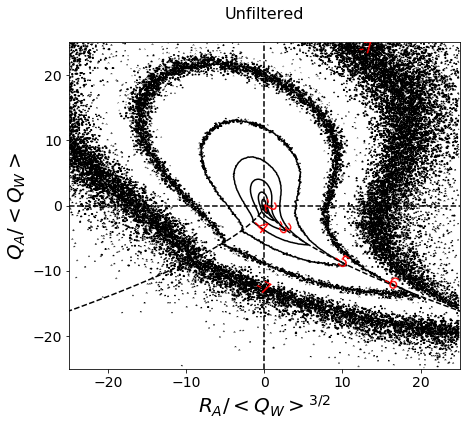

In [21]:
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

fmt={}
plt.figure()
SIZE=12
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE+8)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE+2)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE+2)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)  # legend fontsize
plt.figure(figsize=(7,6))
levels=np.logspace(-7.,-1,num=7,base=10.0)#np.logspace[1e-5,1e-4,1e-3,1e-2,1e-1]
CS=plt.contour(gridX,gridY,jPDF,levels,colors='k')#[1::2] #extent=(-15,15,-15,15)
strs=['-7','-6','-5','-4','-3','-2','-1']
for l,s in zip(CS.levels,strs):
    fmt[l]=s
plt.clabel(CS,levels,inline=False,fmt=fmt,fontsize=16,colors='r')
#plt.colorbar()

# lines
Qc=np.linspace(qmin,0,50)
Rc1=-(2./27.)*((-3.*Qc)**1.5)
Rc2=(2./27.)*((-3.*Qc)**1.5)
plt.plot(Rc1,Qc,'--k')
plt.plot(Rc2,Qc,'--k')
plt.plot([0,0],[qmin,qmax],'--k')
plt.plot([rmin,rmax],[0,0],'--k')
plt.axis([-25,25,-25,25])#rmin,rmax,qmin,qmax
plt.xlabel('$R_A/<Q_W>^{3/2}$')#/\langle Q_W\rangle^{3/2}
plt.ylabel('$Q_A/<Q_W>$')#/\langle Q_W\rangle
plt.title('Unfiltered\n')
plt.show()